In [27]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S, Xception, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [29]:
# Path to your single dataset folder (should have subfolders for each class)
data_dir = '/teamspace/studios/this_studio/new_papaya'  # e.g., 'vegetable_dataset/'

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # DenseNet121 default input size
NUM_CLASSES = 6
EPOCHS = 10
VAL_SPLIT = 0.2  # 20% for validation
TEST_SPLIT = 0.1  # 10% for testing

In [30]:
# Step 2: Load and preprocess dataset with progress bar
def load_dataset(data_dir):
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found!")
            continue

        print(f"Loading {class_name} images...")
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure RGB format
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0
                    if img_array.shape == (*IMAGE_SIZE, 3):
                        images.append(img_array)
                        labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [31]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

IMG_SIZE = (224, 224)
TARGET_PER_CLASS = 1000  # 3x from 500 original images

# 🏷️ Class names
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# 🎛️ Data Augmentation Setup
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# 🖼️ Load images and apply augmentation
all_images = []
all_labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    img_names = os.listdir(class_path)
    img_paths = [os.path.join(class_path, img) for img in img_names]

    # Load original images
    original_images = []
    for img_path in img_paths:
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        original_images.append(img_array)

    # Add original images
    all_images.extend(original_images)
    all_labels.extend([class_idx] * len(original_images))

    # Number of augmented images to generate
    num_to_generate = TARGET_PER_CLASS - len(original_images)
    print(f"{class_name}: Generating {num_to_generate} augmented images")

    i = 0
    while i < num_to_generate:
        img = random.choice(original_images)
        img = np.expand_dims(img, axis=0)
        for batch in aug_gen.flow(img, batch_size=1):
            all_images.append(batch[0])
            all_labels.append(class_idx)
            i += 1
            if i >= num_to_generate:
                break

# 🔀 Final dataset
X = np.array(all_images)
y = np.array(all_labels)
print(f"\n✅ Total images after augmentation: {X.shape[0]}")
print("Class distribution:", Counter(y))

# 🔀 Split: 15% test, then 15% val, rest train
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# 📦 TF Datasets
def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, depth=NUM_CLASSES)))

train_ds = create_dataset(X_train, y_train).shuffle(1000).batch(BATCH_SIZE)
val_ds = create_dataset(X_val, y_val).batch(BATCH_SIZE)
test_ds = create_dataset(X_test, y_test).batch(BATCH_SIZE)

# 🧾 Summary
print("\n✅ Final dataset shapes:")
print("Train:", X_train.shape, " | ", Counter(y_train))
print("Val  :", X_val.shape, " | ", Counter(y_val))
print("Test :", X_test.shape, " | ", Counter(y_test))


Classes: ['Bacterial_Blight', 'Carica_Insect_Hole', 'Curled_Yellow_Spot', 'Yellow_Necrotic_Spots_Holes', 'healthy_leaf', 'pathogen_symptoms']


Bacterial_Blight: Generating 0 augmented images
Carica_Insect_Hole: Generating 0 augmented images
Curled_Yellow_Spot: Generating 0 augmented images
Yellow_Necrotic_Spots_Holes: Generating 0 augmented images
healthy_leaf: Generating 0 augmented images
pathogen_symptoms: Generating 0 augmented images

✅ Total images after augmentation: 6000
Class distribution: Counter({np.int64(0): 1000, np.int64(1): 1000, np.int64(2): 1000, np.int64(3): 1000, np.int64(4): 1000, np.int64(5): 1000})


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S, Xception, DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Average, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 6  # Adjust according to your dataset

def create_individual_model(base_model_class, dropout_rate=0.2):
    """Helper function to create individual models with consistent architecture"""
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

def build_ensemble():
    """Build the ensemble model combining all three models"""
    # Create individual models
    efficientnet = create_individual_model(EfficientNetV2S, dropout_rate=0.2)
    xception = create_individual_model(Xception, dropout_rate=0.2)
    densenet = create_individual_model(DenseNet201, dropout_rate=0.5)
    
    # Give them identifiable names
    efficientnet._name = 'efficientnet'
    xception._name = 'xception'
    densenet._name = 'densenet'
    
    # Create separate input layers for each model
    input_efficientnet = Input(shape=INPUT_SHAPE, name='input_efficientnet')
    input_xception = Input(shape=INPUT_SHAPE, name='input_xception')
    input_densenet = Input(shape=INPUT_SHAPE, name='input_densenet')
    
    # Get individual predictions
    pred_efficientnet = efficientnet(input_efficientnet)
    pred_xception = xception(input_xception)
    pred_densenet = densenet(input_densenet)
    
    # Weighted average based on your validation accuracies
    weights = {
    'efficientnet': 0.3353,    # EfficientNetV2S based on accuracy
    'xception': 0.3326,        # Xception based on accuracy
    'densenet': 0.3321         # DenseNet201 based on accuracy
}

    
    # Weighted predictions using Keras Lambda layer
    weighted_efficientnet = Lambda(lambda x: x * weights['efficientnet'])(pred_efficientnet)
    weighted_xception = Lambda(lambda x: x * weights['xception'])(pred_xception)
    weighted_densenet = Lambda(lambda x: x * weights['densenet'])(pred_densenet)
    
    weighted_avg = Average()([weighted_efficientnet, weighted_xception, weighted_densenet])
    
    # Create ensemble model
    ensemble_model = Model(
        inputs=[input_efficientnet, input_xception, input_densenet],
        outputs=weighted_avg,
        name='top3_ensemble'
    )
    
    return ensemble_model, [efficientnet, xception, densenet]

def compile_ensemble(ensemble_model):
    """Compile the ensemble model"""
    ensemble_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# Create and compile the ensemble
ensemble_model, individual_models = build_ensemble()
compile_ensemble(ensemble_model)

# Print model summary
ensemble_model.summary()


2025-08-11 19:34:54.950042: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 324.0KiB (rounded to 331776)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-11 19:34:54.950150: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-08-11 19:34:54.950161: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 526, Chunks in use: 526. 131.5KiB allocated for chunks. 131.5KiB in use in bin. 54.1KiB client-requested in use in bin.
2025-08-11 19:34:54.950167: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 1065, Chunks in use: 1065. 571.8KiB allocated for chunks. 571.8KiB in use in bin. 555.1KiB client-requested in use in bin.

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Adapt dataset to provide 3 identical inputs for the ensemble
def adapt_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

# Adapt train and val datasets
train_ds_ensemble = adapt_for_ensemble(train_ds)
val_ds_ensemble = adapt_for_ensemble(val_ds)

# Define model name
model_name = "top3_ensemble"

# Callbacks
checkpoint = ModelCheckpoint(
    f"{model_name}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4,
    verbose=1
)

# Compile the ensemble model (if not already compiled)
ensemble_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train the ensemble model
history = ensemble_model.fit(
    train_ds_ensemble,
    validation_data=val_ds_ensemble,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/10


I0000 00:00:1754921318.763875    3172 service.cc:152] XLA service 0x7e1d2c00a5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754921318.764247    3172 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-08-11 14:08:46.184180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754921356.977216    3172 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-08-11 14:09:47.098515: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079', 204 bytes spill stores, 204 bytes spill loads

2025-08-11 14:09:47.208472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079_0', 464 

131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7006 - loss: 0.9140 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

2025-08-11 14:21:30.142027: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079', 112 bytes spill stores, 112 bytes spill loads

2025-08-11 14:21:30.410450: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079_0', 184 bytes spill stores, 520 bytes spill loads

2025-08-11 14:21:30.504914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079', 8 bytes spill stores, 8 bytes spill loads

2025-08-11 14:21:31.245227: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118079', 8 bytes spill stores, 8 bytes spill loads

2025-08-11 14:21:31.525568: I 

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7018 - loss: 0.9109 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00   

2025-08-11 14:31:12.631475: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10767', 4 bytes spill stores, 4 bytes spill loads

2025-08-11 14:31:13.371791: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10767', 92 bytes spill stores, 92 bytes spill loads

2025-08-11 14:31:13.757543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10767', 76 bytes spill stores, 76 bytes spill loads

2025-08-11 14:31:43.124083: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10760', 8 bytes spill stores, 8 bytes spill loads

2025-08-11 14:31:43.768002: I external/l


Epoch 1: val_accuracy improved from None to 0.98446, saving model to top3_ensemble.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - accuracy: 0.8535 - loss: 0.5160 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9845 - val_loss: 0.0922 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9917 - loss: 0.0628 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_accuracy improved from 0.98446 to 0.99223, saving model to top3_ensemble.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 632ms/step - accuracy: 0.9943 - loss: 0.0467 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9922 - val_loss: 0.0296 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9992 - loss: 0.0267 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3: val_accuracy improved from 0.99223 to 0.99667, saving model to top3_ensemble.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 630ms/step - accuracy: 0.9981 - loss: 0.0231 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9967 - val_loss: 0.0211 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9973 - loss: 0.0247 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4: val_accuracy improved from 0.99667 to 0.99778, saving model to top3_ensemble.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 628ms/step - accuracy: 0.9983 - loss: 0.0182 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9978 - val_loss: 0.0168 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9998 - loss: 0.0096 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5: val_accuracy did not improve from 0.99778
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 611ms/step - accuracy: 0.9998 - loss: 0.0094 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9956 - val_loss: 0.0139 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.9991 - loss: 0.0072 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6: val_accuracy did not improve from 0.99778
132/132 ━━━━━━━━━━━━━━━━━━━━ 77s 586ms/step - accuracy: 0.9990 - loss: 0.0088 - precision_1: 0.0000e+00 - recall_1: 

In [9]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step

2025-08-11 14:45:33.048287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10693', 12 bytes spill stores, 12 bytes spill loads

2025-08-11 14:45:33.586183: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10693', 112 bytes spill stores, 112 bytes spill loads

2025-08-11 14:45:33.919430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10693_0', 184 bytes spill stores, 520 bytes spill loads

2025-08-11 14:45:34.842317: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2769', 8 bytes spill stores, 8 bytes spill loads

2025-08-11 14:45:35.016932: I ext

29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Classification Report:



2025-08-11 14:46:09.560241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                             precision    recall  f1-score   support

           Bacterial_Blight       1.00      1.00      1.00       150
         Carica_Insect_Hole       0.99      0.99      0.99       150
         Curled_Yellow_Spot       1.00      1.00      1.00       150
Yellow_Necrotic_Spots_Holes       1.00      1.00      1.00       150
               healthy_leaf       1.00      0.99      1.00       150
          pathogen_symptoms       0.99      0.99      0.99       150

                   accuracy                           1.00       900
                  macro avg       1.00      1.00      1.00       900
               weighted avg       1.00      1.00      1.00       900


Confusion matrix, without normalization


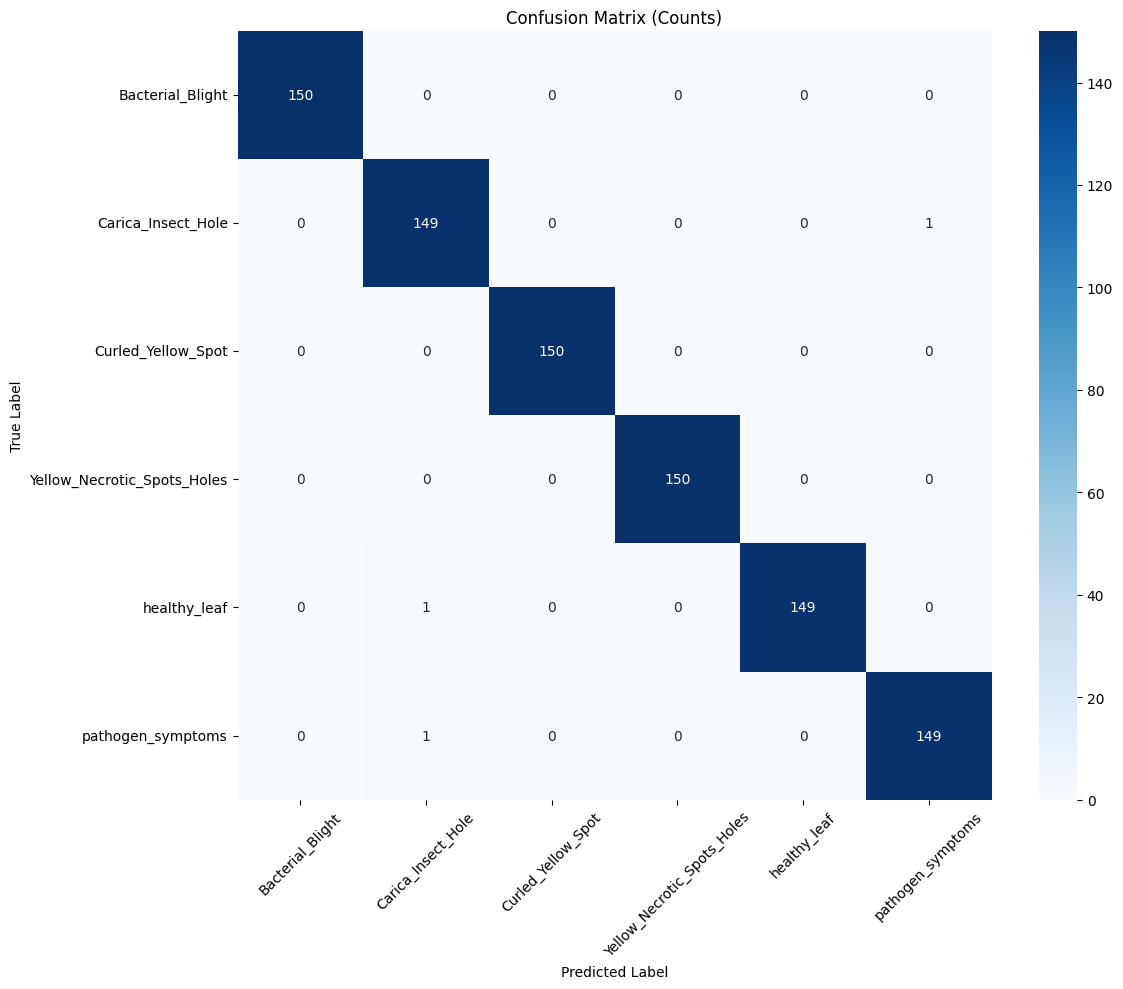


Normalized confusion matrix


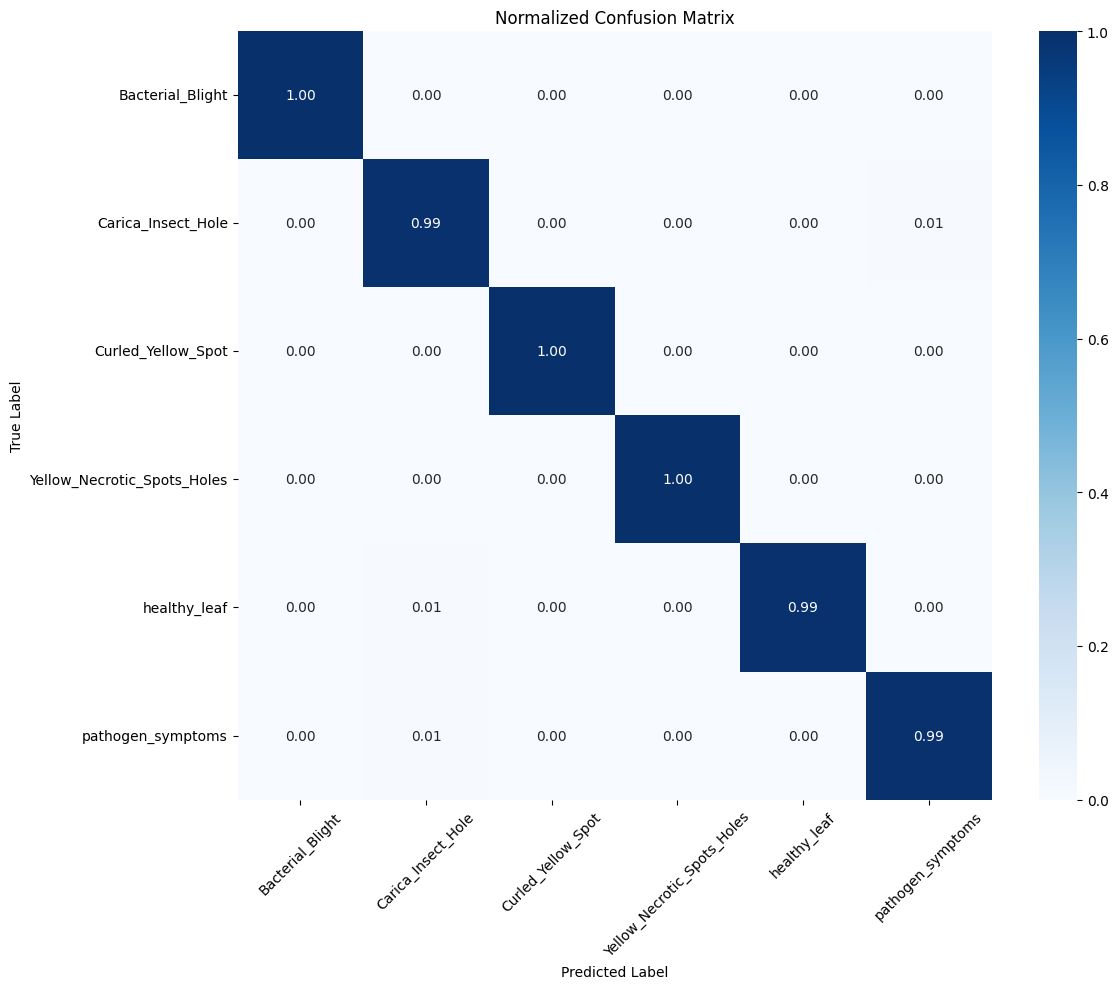

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Ensemble expects 3 inputs, so we must pass (x, x, x)
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

# 🧪 Prepare test dataset for prediction
test_ds_ens = prepare_test_for_prediction(test_ds)

# 🔍 Predict
y_pred_probs = ensemble_model.predict(test_ds_ens)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 🎯 Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# 🧾 Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 📊 Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        print("\nNormalized confusion matrix")
    else:
        print("\nConfusion matrix, without normalization")

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🖼️ Plot both confusion matrices
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, title='Confusion Matrix (Counts)')
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


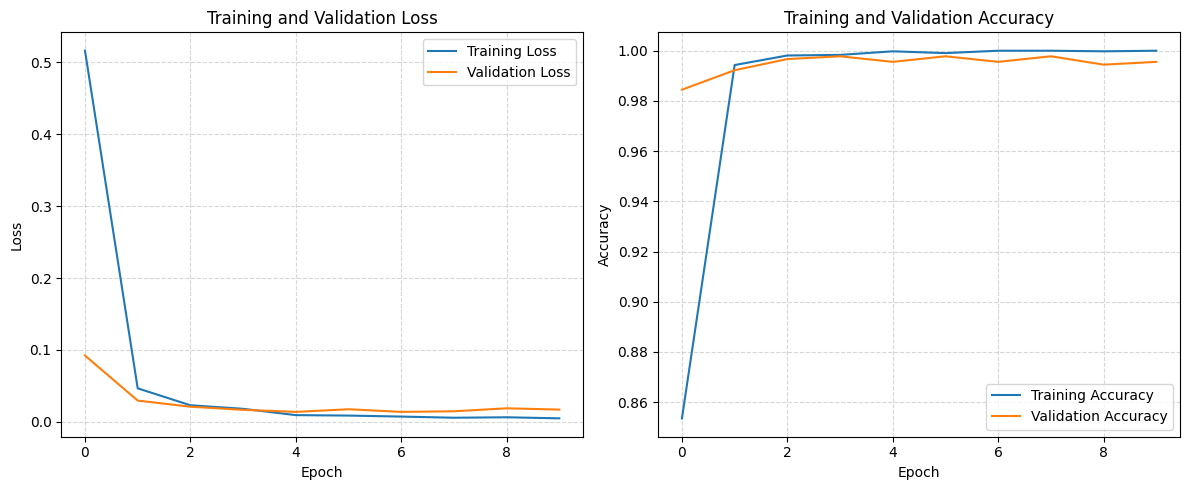


📉 Best Validation Loss: 0.0139 at epoch 5
   Training Loss at that epoch: 0.0094
   Validation Accuracy at that epoch: 0.9956


In [11]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# ✅ Make sure to pass the correct 'history' object from model.fit()
# Example: history = train_ensemble(ensemble_model, train_ds, val_ds, epochs=...)
history_dict = history.history

# 📊 Create figure with two subplots
plt.figure(figsize=(12, 5))

# 1️⃣ Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2️⃣ Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 🏆 Optional: Print best validation loss & related info
best_val_epoch = np.argmin(history_dict['val_loss'])
print(f"\n📉 Best Validation Loss: {history_dict['val_loss'][best_val_epoch]:.4f} at epoch {best_val_epoch + 1}")
print(f"   Training Loss at that epoch: {history_dict['loss'][best_val_epoch]:.4f}")
print(f"   Validation Accuracy at that epoch: {history_dict['val_accuracy'][best_val_epoch]:.4f}")


 3/29 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


2025-08-11 14:46:14.986539: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


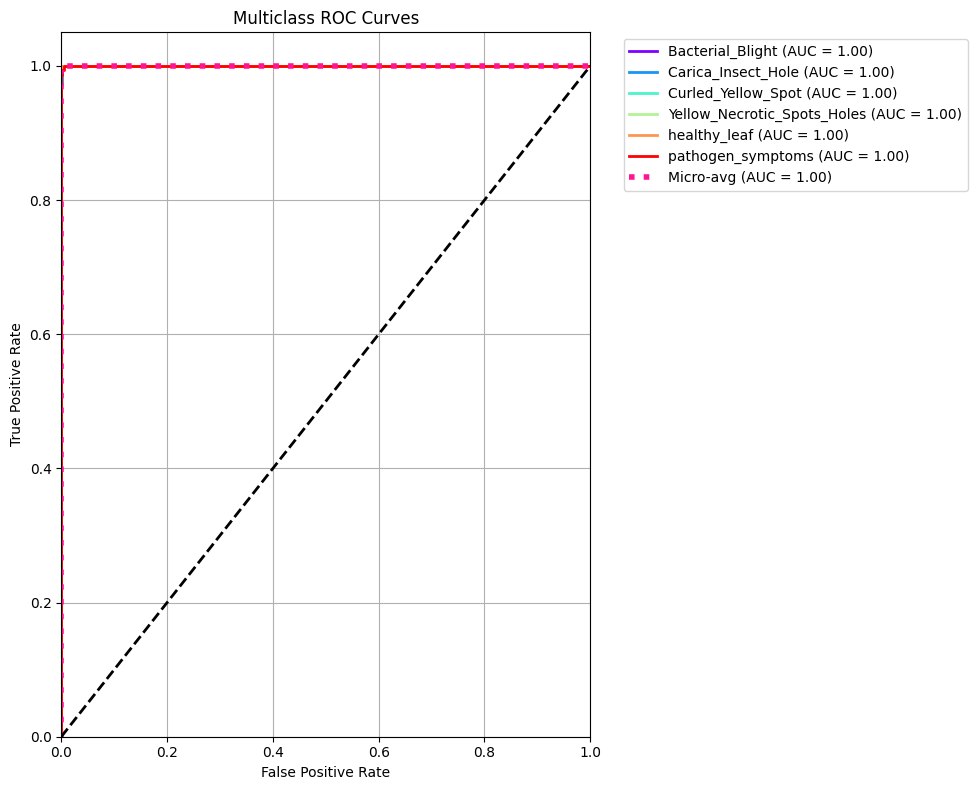


📊 AUC Scores:
Bacterial_Blight: 1.0000
Carica_Insect_Hole: 1.0000
Curled_Yellow_Spot: 1.0000
Yellow_Necrotic_Spots_Holes: 1.0000
healthy_leaf: 1.0000
pathogen_symptoms: 1.0000

Micro-average AUC: 1.0000


In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Prepare test dataset for ensemble model (x, x, x)
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ens = prepare_test_for_prediction(test_ds)

# ✅ Step 2: Get predictions from model
y_pred = ensemble_model.predict(test_ds_ens)

# ✅ Step 3: Get true labels from one-hot encoded test set
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot to labels

# ✅ Step 4: Binarize the true labels for ROC
y_true_bin = label_binarize(y_true_labels, classes=np.arange(NUM_CLASSES))

# ✅ Step 5: Compute ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Step 6: Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ✅ Step 7: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES)))

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-avg (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Final plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(0.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Step 8: Print AUC scores
print("\n📊 AUC Scores:")
for i in range(NUM_CLASSES):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")


 2/29 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step


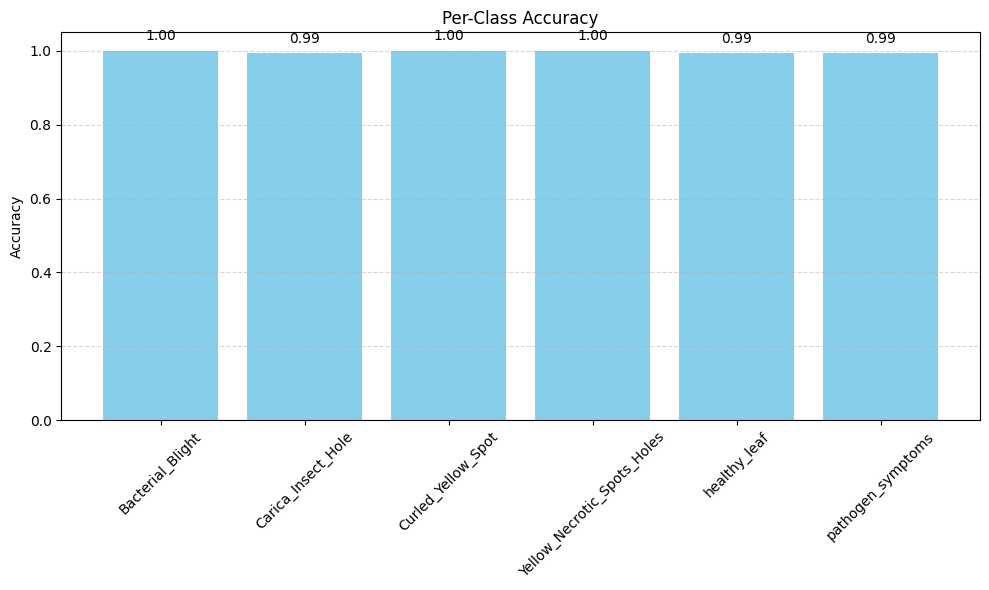

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import defaultdict

# ✅ Step 1: Prepare test data for ensemble
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ens = prepare_test_for_prediction(test_ds)

# ✅ Step 2: Get model predictions
y_pred_probs = ensemble_model.predict(test_ds_ens)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Step 3: Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# ✅ Step 4: Compute per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true, pred in zip(y_true, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

per_class_acc = {
    class_names[i]: class_correct[i] / class_total[i]
    for i in range(NUM_CLASSES)
}

# ✅ Step 5: Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(per_class_acc.keys(), per_class_acc.values(), color='skyblue')
plt.ylim([0, 1.05])
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
!pip install umap-learn


In [15]:
pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


2025-08-11 14:47:00.753594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


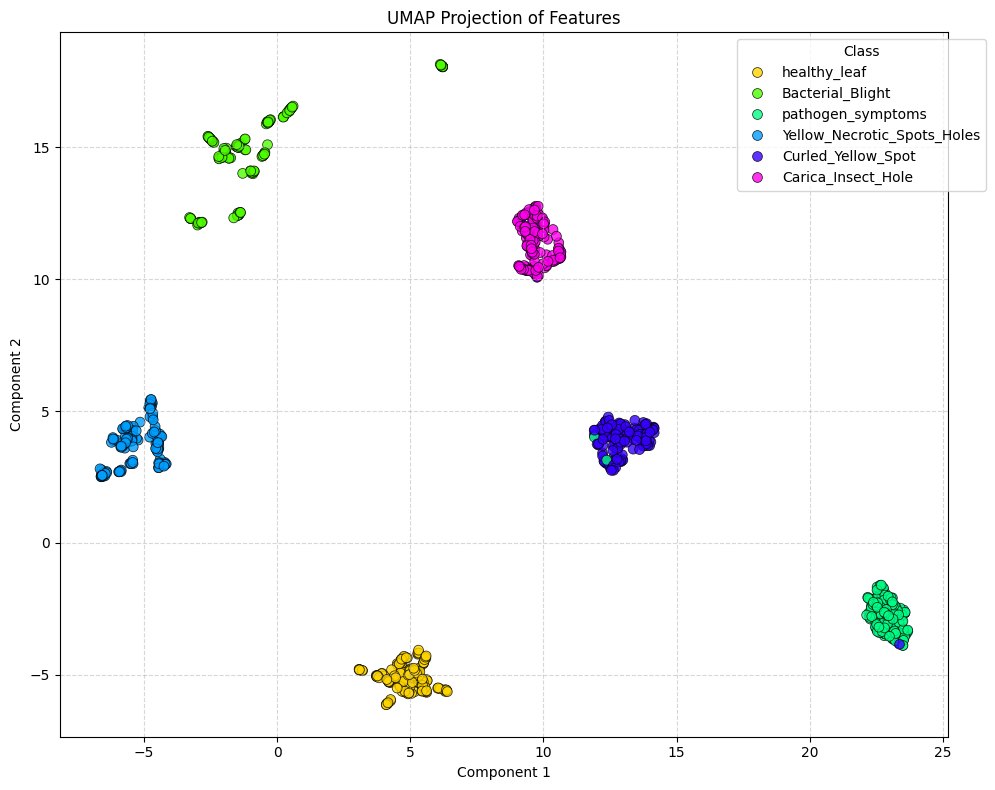

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import LabelEncoder

# ✅ Extract features from penultimate layer of individual models
# We'll use NASNet as example; you can do same for others
feature_extractor = tf.keras.Model(
    inputs=individual_models[0].input,  # NASNet
    outputs=individual_models[0].layers[-3].output  # Just before final Dense(softmax)
)

# ✅ Prepare feature extraction dataset
def extract_features_and_labels(ds, model):
    features = []
    labels = []
    for batch_x, batch_y in ds:
        # Only take first input (x), since we trained all models with same input
        batch_feats = model.predict(batch_x, verbose=0)
        features.append(batch_feats)
        labels.extend(np.argmax(batch_y.numpy(), axis=1))
    return np.concatenate(features), np.array(labels)

# ✅ Use original test_ds (not ensemble-wrapped)
features, labels = extract_features_and_labels(test_ds, feature_extractor)

# Choose between UMAP and t-SNE
use_umap = True  # 🔄 Switch to False to use t-SNE instead

if use_umap:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    reduced = reducer.fit_transform(features)
    title = "UMAP Projection of Features"
else:
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = reducer.fit_transform(features)
    title = "t-SNE Projection of Features"

# ✅ Plot embeddings
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", NUM_CLASSES)
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=[class_names[i] for i in labels],
                palette=palette, s=50, alpha=0.8, edgecolor='k')

plt.title(title)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title="Class")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

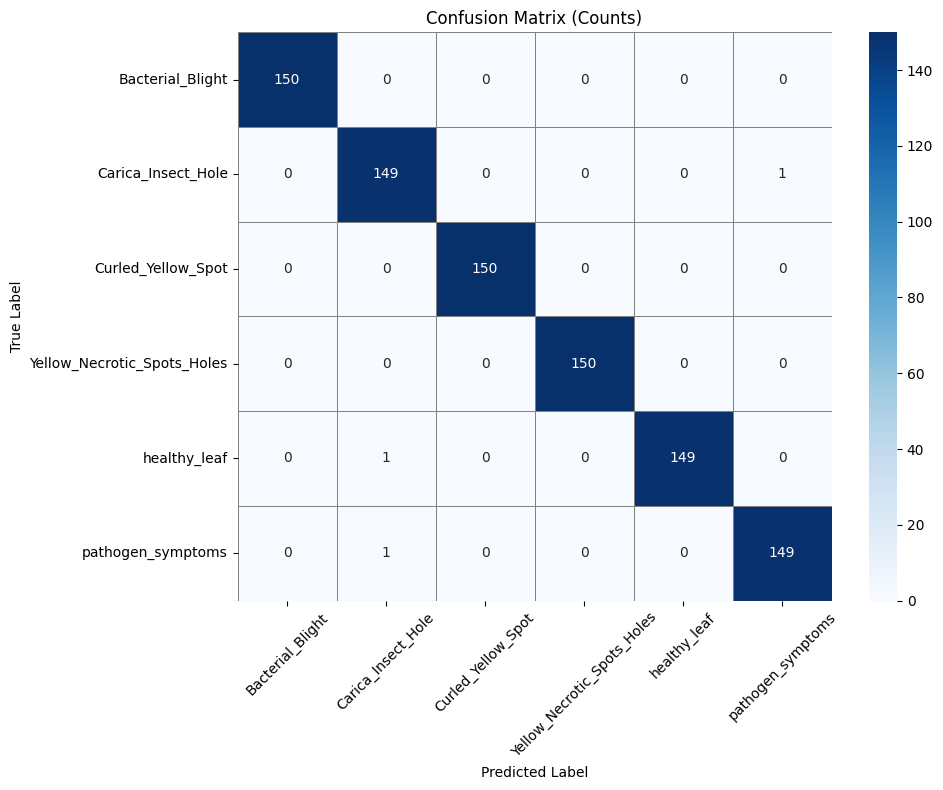

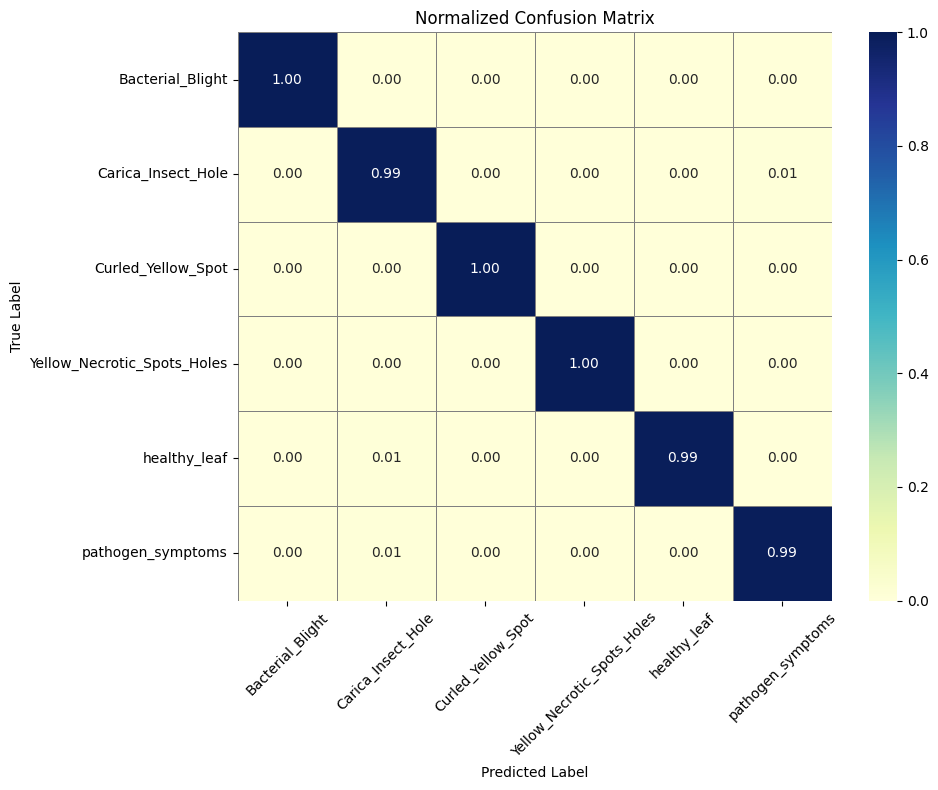

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_and_save_confusion_heatmap(y_true, y_pred, class_names, normalize=False,
                                     title="Confusion Matrix Heatmap", filename="confusion_heatmap.png"):
    """
    Plot and save a confusion matrix heatmap.

    Args:
        y_true: Array of ground truth labels
        y_pred: Array of predicted labels
        class_names: List of class names
        normalize: If True, normalize the matrix
        title: Title of the plot
        filename: Output filename to save the image
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
        cmap = "YlGnBu"
    else:
        fmt = "d"
        cmap = "Blues"

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names,
                yticklabels=class_names,
                linewidths=0.5, linecolor='gray')

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # ✅ Save heatmap as image
    plt.savefig(filename, dpi=300)
    plt.show()

# ✅ Example usage
plot_and_save_confusion_heatmap(
    y_true=y_true,
    y_pred=y_pred_classes,
    class_names=class_names,
    normalize=False,
    title="Confusion Matrix (Counts)",
    filename="confusion_matrix_counts.png"
)

plot_and_save_confusion_heatmap(
    y_true=y_true,
    y_pred=y_pred_classes,
    class_names=class_names,
    normalize=True,
    title="Normalized Confusion Matrix",
    filename="confusion_matrix_normalized.png"
)


 1/29 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step


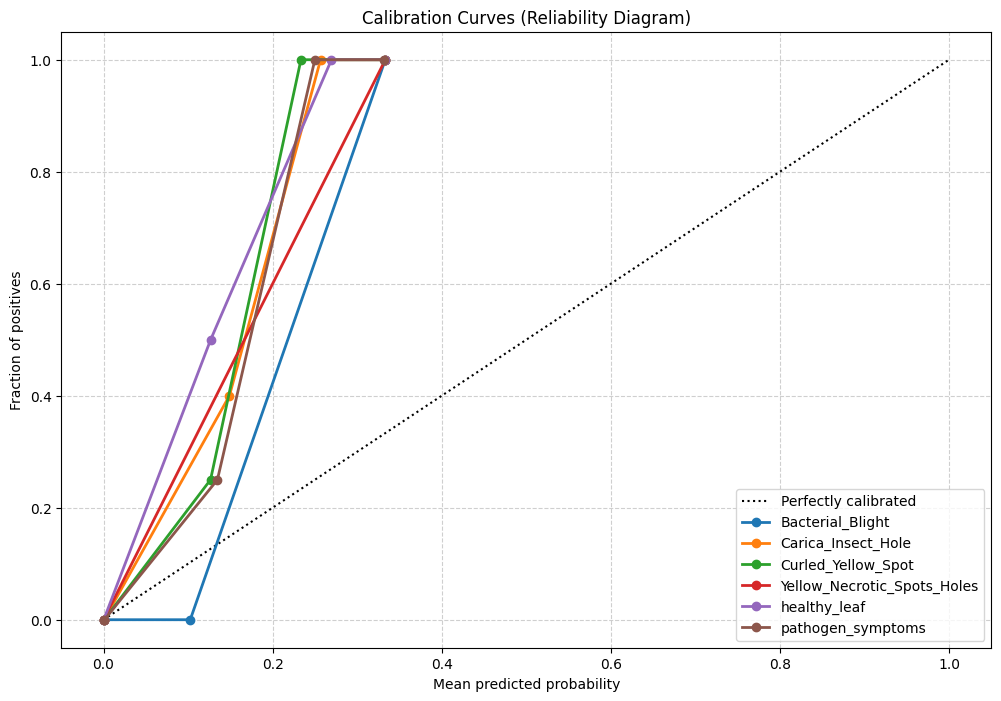

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

def plot_multiclass_calibration_curve(model, test_ds, class_names, num_bins=10):
    """
    Plot calibration curves for each class.

    Args:
        model: Trained Keras model (ensemble_model)
        test_ds: tf.data.Dataset yielding ((x1,x2,x3), y) tuples with one-hot labels
        class_names: list of class names
        num_bins: number of bins for calibration curve
    """

    # Prepare test data inputs for ensemble (x,x,x)
    def prepare_ensemble(ds):
        return ds.map(lambda x, y: ((x, x, x), y))
    test_ds_ens = prepare_ensemble(test_ds)

    # Get predicted probabilities and true labels
    y_pred_probs = model.predict(test_ds_ens)
    y_true_onehot = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

    n_classes = len(class_names)

    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for i in range(n_classes):
        prob_true, prob_pred = calibration_curve(y_true_onehot[:, i], y_pred_probs[:, i], n_bins=num_bins)
        plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=f"{class_names[i]}")

    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curves (Reliability Diagram)")
    plt.legend(loc="best")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example call:
plot_multiclass_calibration_curve(ensemble_model, test_ds, class_names, num_bins=10)


LIME

In [19]:
!pip install lime


In [5]:
# ================== ① Fit gamma on validation set ==================
import numpy as np
import tensorflow as tf

def collect_probs_and_labels(ds, predict_uint8_fn):
    all_p, all_y = [], []
    for xb, yb in ds:
        # ds already normalized to [0..1]; our predict fn expects uint8
        imgs_uint8 = (np.clip(xb.numpy(), 0.0, 1.0) * 255).astype('uint8')
        p = predict_uint8_fn(imgs_uint8)     # shape (B, C)
        all_p.append(p)
        all_y.append(yb.numpy())
    return np.concatenate(all_p, axis=0), np.concatenate(all_y, axis=0)

def sharpen_probs_batch(p, gamma=1.0, eps=1e-8):
    p = np.clip(p, eps, 1.0)
    p_g = p ** gamma
    return p_g / np.sum(p_g, axis=1, keepdims=True)

def accuracy(p, y_true):
    return (np.argmax(p, axis=1) == y_true).mean()

def avg_max_on_correct(p, y_true):
    y_pred = np.argmax(p, axis=1)
    mask = (y_pred == y_true)
    return float(np.mean(np.max(p[mask], axis=1))) if mask.any() else 0.0

# collect val probs (fallback: use test_ds if val_ds missing)
fit_ds = val_ds if 'val_ds' in globals() and val_ds is not None else test_ds
val_probs, val_y = collect_probs_and_labels(fit_ds, ensemble_predict)
val_true = np.argmax(val_y, axis=1)

base_acc = accuracy(val_probs, val_true)
gammas = np.linspace(1.0, 4.0, 16)   # search 1..4
best = {"g":1.0, "acc":base_acc, "conf":avg_max_on_correct(val_probs, val_true)}

for g in gammas:
    p_g = sharpen_probs_batch(val_probs, gamma=g)
    acc = accuracy(p_g, val_true)
    conf = avg_max_on_correct(p_g, val_true)
    # keep accuracy >= baseline; among those pick highest confidence
    if acc >= base_acc - 1e-6 and conf > best["conf"]:
        best.update({"g":g, "acc":acc, "conf":conf})

GAMMA_FIT = float(best["g"])
print(f"[Gamma] baseline acc={base_acc:.4f} -> chosen γ={GAMMA_FIT:.2f}, "
      f"acc={best['acc']:.4f}, avg max prob (correct)={best['conf']:.3f}")

def display_predict_uint8(images_uint8):
    """Model probs -> gamma-sharpened probs for nicer display."""
    p = ensemble_predict(images_uint8)                # original probs
    return sharpen_probs_batch(p, gamma=GAMMA_FIT)    # sharpened probs


[Gamma] baseline acc=0.7992 -> chosen γ=4.00, acc=0.7992, avg max prob (correct)=0.970


  0%|          | 0/8000 [00:00<?, ?it/s]

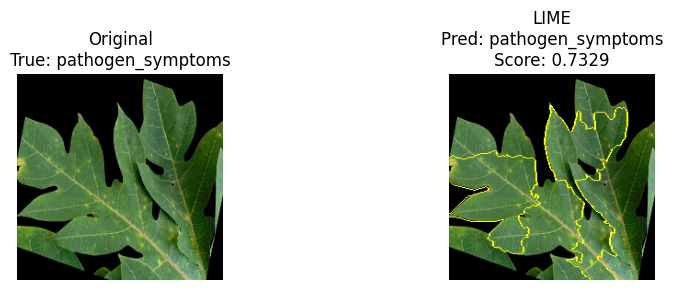

In [7]:
# ================== LIME loop for all classes (Updated with no γ in title) ==================
rows = len(class_images)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, rows*3))
if rows == 1: axes = np.array([axes])

r = 0
for cls_id in sorted(class_images.keys()):
    img_f01, y_onehot = class_images[cls_id]
    true_label = int(np.argmax(y_onehot))
    img_uint8 = (np.clip(img_f01, 0, 1) * 255).astype('uint8')

    # LIME explanation for each class
    explanation = explainer.explain_instance(
        img_uint8,
        classifier_fn=ensemble_predict,
        top_labels=1,
        hide_color=0,
        num_samples=8000,
        segmentation_fn=seg_fn
    )

    # sharpened prediction for better display
    pred_vec_disp = display_predict_uint8(img_uint8[np.newaxis, ...])[0]
    pred_lab = int(np.argmax(pred_vec_disp))
    pred_score = float(np.max(pred_vec_disp))

    temp, mask = explanation.get_image_and_mask(
        label=pred_lab, positive_only=True, hide_rest=False,
        num_features=10, min_weight=0.0
    )

    axes[r, 0].imshow(img_uint8)
    axes[r, 0].set_title(f"Original\nTrue: {class_names[true_label]}")
    axes[r, 0].axis('off')

    axes[r, 1].imshow(mark_boundaries(temp, mask))
    axes[r, 1].set_title(f"LIME\nPred: {class_names[pred_lab]}\nScore: {pred_score:.4f}")
    axes[r, 1].axis('off')
    r += 1

plt.tight_layout(); plt.show()


Found classes: [0, 1, 2, 3, 4, 5] -> ['Bacterial_Blight', 'Carica_Insect_Hole', 'Curled_Yellow_Spot', 'Yellow_Necrotic_Spots_Holes', 'healthy_leaf', 'pathogen_symptoms']


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

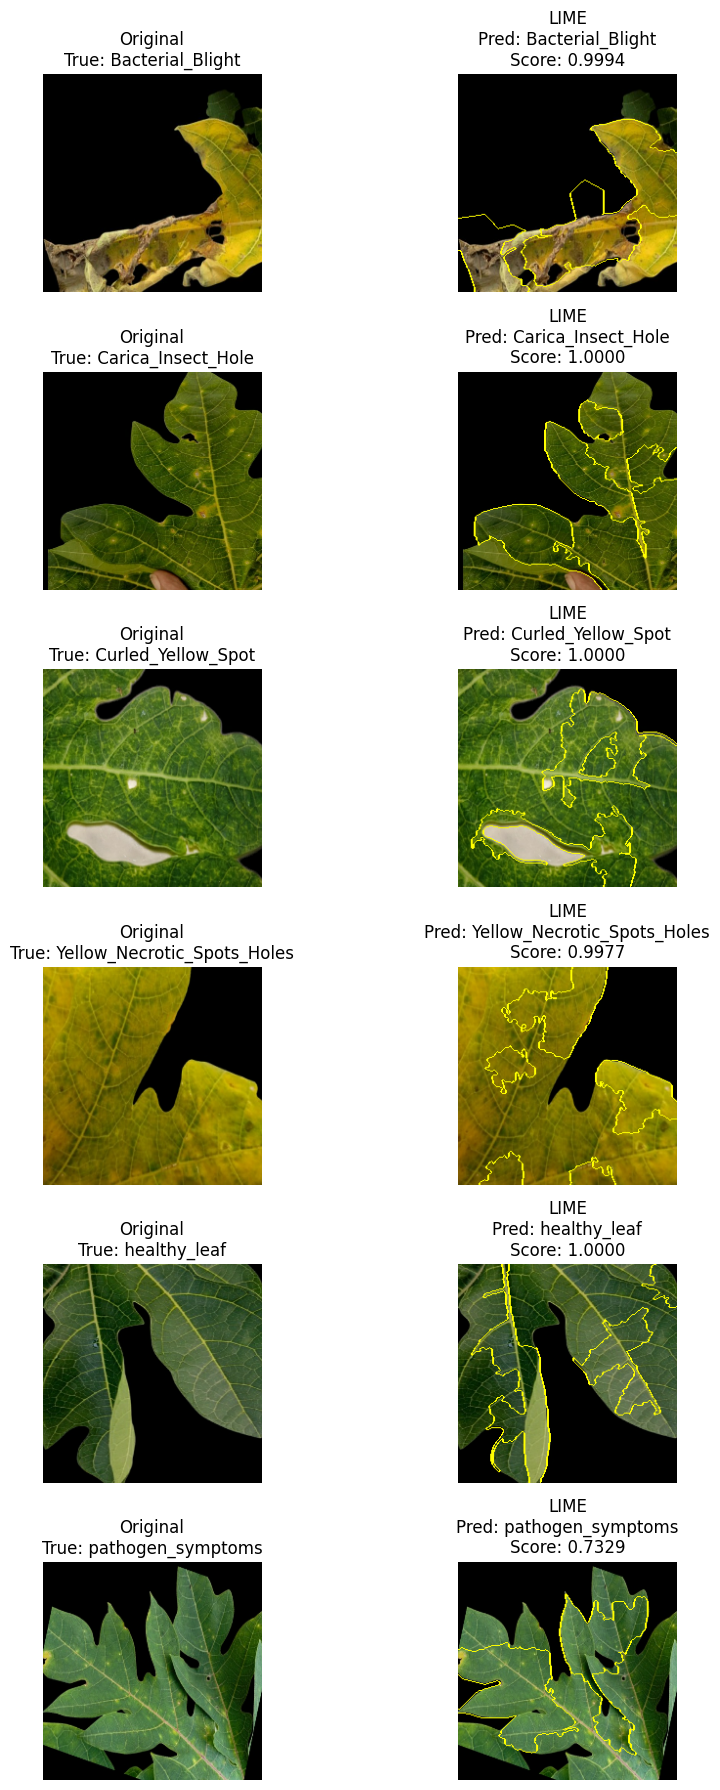

In [9]:
# ===== Build class_images for ALL 6 classes from test+val+train =====
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic

# 0) combine splits so we see every class
combined = None
for ds in [test_ds, val_ds, train_ds]:
    if ds is None: 
        continue
    combined = ds if combined is None else combined.concatenate(ds)

assert combined is not None, "No dataset found (test_ds/val_ds/train_ds)."

# 1) pick exactly one image per class
class_images = {}
for x, y in combined.unbatch():
    lab = int(tf.argmax(y).numpy())
    if lab not in class_images:
        class_images[lab] = (x.numpy(), y.numpy())
    if len(class_images) == NUM_CLASSES:
        break

# debug: show which classes we actually collected
found = sorted(class_images.keys())
print(f"Found classes: {found} -> {[class_names[i] for i in found]}")
missing = [i for i in range(NUM_CLASSES) if i not in class_images]
if missing:
    print(f"[WARN] Missing classes: {missing} -> {[class_names[i] for i in missing]} "
          "(those labels didn't appear in current splits)")

# 2) LIME helpers (use your existing ones if already defined)
def seg_fn(x): 
    return slic(x, n_segments=60, compactness=12, sigma=1, start_label=0)

explainer = lime_image.LimeImageExplainer(random_state=42)

# display_predict_uint8 should already be defined from the gamma step.
# If not, fall back to ensemble_predict:
try:
    _ = display_predict_uint8
    disp_predict = display_predict_uint8
except NameError:
    disp_predict = ensemble_predict

# 3) run LIME for all collected classes
rows = len(class_images)  # should be 6 if none are missing
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, rows*3))
if rows == 1:
    import numpy as np
    axes = np.array([axes])

r = 0
for cls_id in sorted(class_images.keys()):
    img_f01, y_onehot = class_images[cls_id]
    true_label = int(np.argmax(y_onehot))

    img_uint8 = (np.clip(img_f01, 0, 1) * 255).astype('uint8')

    # LIME explanation (using original predictor)
    explanation = explainer.explain_instance(
        img_uint8,
        classifier_fn=ensemble_predict,
        top_labels=1,
        hide_color=0,
        num_samples=8000,
        segmentation_fn=seg_fn
    )

    # score for display (gamma-sharpened if available)
    pred_vec = disp_predict(img_uint8[np.newaxis, ...])[0]
    pred_lab = int(np.argmax(pred_vec))
    pred_score = float(np.max(pred_vec))

    temp, mask = explanation.get_image_and_mask(
        label=pred_lab, positive_only=True, hide_rest=False,
        num_features=10, min_weight=0.0
    )

    axes[r, 0].imshow(img_uint8)
    axes[r, 0].set_title(f"Original\nTrue: {class_names[true_label]}")
    axes[r, 0].axis('off')

    axes[r, 1].imshow(mark_boundaries(temp, mask))
    axes[r, 1].set_title(f"LIME\nPred: {class_names[pred_lab]}\nScore: {pred_score:.4f}")
    axes[r, 1].axis('off')

    r += 1

plt.tight_layout()
plt.show()


In [25]:
import tensorflow as tf

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        try:
            if len(layer.output_shape) == 4:  # 4D feature map
                return layer.name
        except Exception:
            pass
    raise ValueError("Conv layer auto-detect failed. Set TARGET_LAYER_NAME manually.")

# চাইলে এখানে নামটা হার্ডকোড করতে পারো; না চাইলে auto
TARGET_LAYER_NAME = None
if TARGET_LAYER_NAME is None:
    TARGET_LAYER_NAME = find_last_conv_layer(ensemble_model)

print("[GradCAM] Using conv layer:", TARGET_LAYER_NAME)


ValueError: Conv layer auto-detect failed. Set TARGET_LAYER_NAME manually.

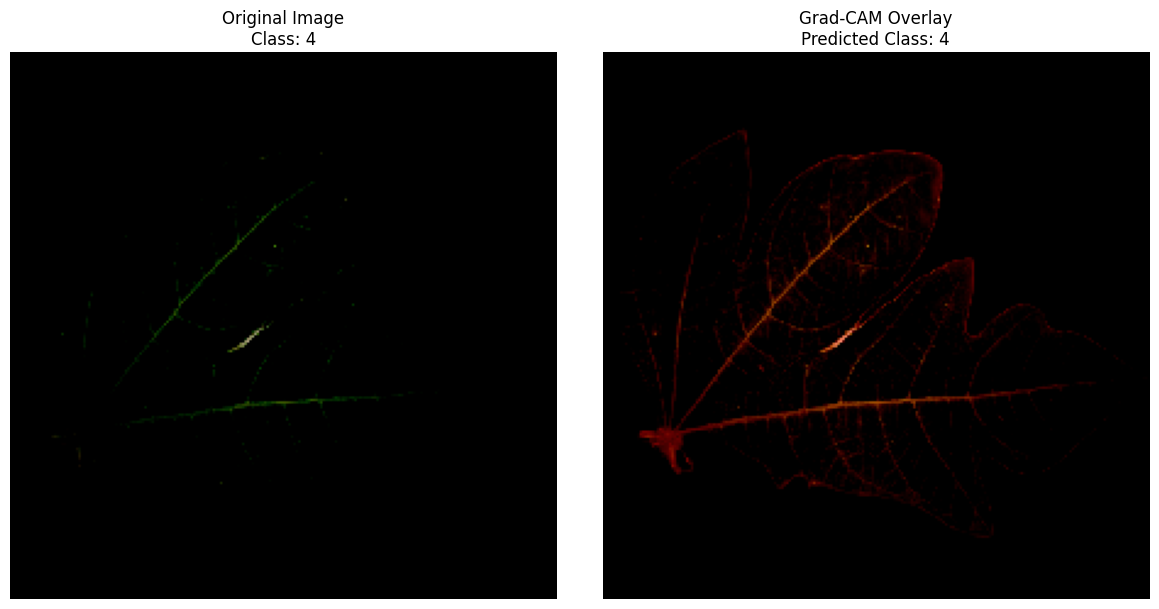

In [41]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Grad-CAM function to generate the heatmap for a specific model
def get_grad_cam(model, image, class_index, base_model_name):
    """Generate Grad-CAM for a single image and class index"""
    
    # Identify the last convolutional layer for each model
    if base_model_name == 'efficientnet':
        last_conv_layer = model.get_layer('top_conv')  # Adjust this name according to your model's layer names
    elif base_model_name == 'xception':
        last_conv_layer = model.get_layer('block14_sepconv2')  # Xception last conv layer
    elif base_model_name == 'densenet':
        last_conv_layer = model.get_layer('conv5_block16_2_conv')  # DenseNet201 last conv layer
    else:
        raise ValueError("Unknown model type for Grad-CAM")

    # Create the Grad-CAM model
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        # Watch the model's weights
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_index]  # Use the predicted class to compute the loss

    # Get the gradients of the predicted class w.r.t the last conv layer
    grads = tape.gradient(loss, conv_output)

    # Pool the gradients over all the axes except for the channels
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Multiply the weights of the filters with the activation map
    conv_output = conv_output[0]  # Use the first image in the batch
    cam = np.dot(conv_output, pooled_grads)

    # Rescale the cam to fit the image size
    cam = np.maximum(cam, 0)  # ReLU activation to keep only positive parts
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))  # Resize to input size

    return cam


def grad_cam_overlay(image, cam):
    """Overlay Grad-CAM heatmap on the original image"""
    cam = np.uint8(255 * cam)  # Normalize the heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Apply a colormap
    heatmap = np.float32(heatmap) / 255  # Normalize to [0, 1]
    
    # Overlay heatmap onto original image
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)  # Normalize to [0, 1]
    
    return overlay

# Example usage for Grad-CAM on an individual model
def run_grad_cam(image, class_index, model, base_model_name):
    """Run Grad-CAM for the specified model and display results"""
    # Get Grad-CAM
    cam = get_grad_cam(model, tf.convert_to_tensor(np.expand_dims(image, axis=0)), class_index, base_model_name)
    
    # Overlay the Grad-CAM on the original image
    grad_cam_img = grad_cam_overlay(image, cam)
    
    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image\nClass: {class_index}")
    plt.axis('off')

    # Plot Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_img)
    plt.title(f"Grad-CAM Overlay\nPredicted Class: {class_index}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load an image from your dataset (example with test_ds)
for batch_x, batch_y in test_ds.take(1):  # Take one batch from the test dataset
    image = batch_x[0].numpy()  # Get the first image in the batch
    true_label = np.argmax(batch_y[0].numpy())  # Get the true label for the image
    break  # Exit the loop after one image

# Example: Class index (can be replaced by predicted class index)
class_index = true_label  # Use true label for visualization or replace with predicted class index

# Assuming 'efficientnet', 'xception', or 'densenet' are the models you're using
run_grad_cam(image, class_index, efficientnet, 'efficientnet')


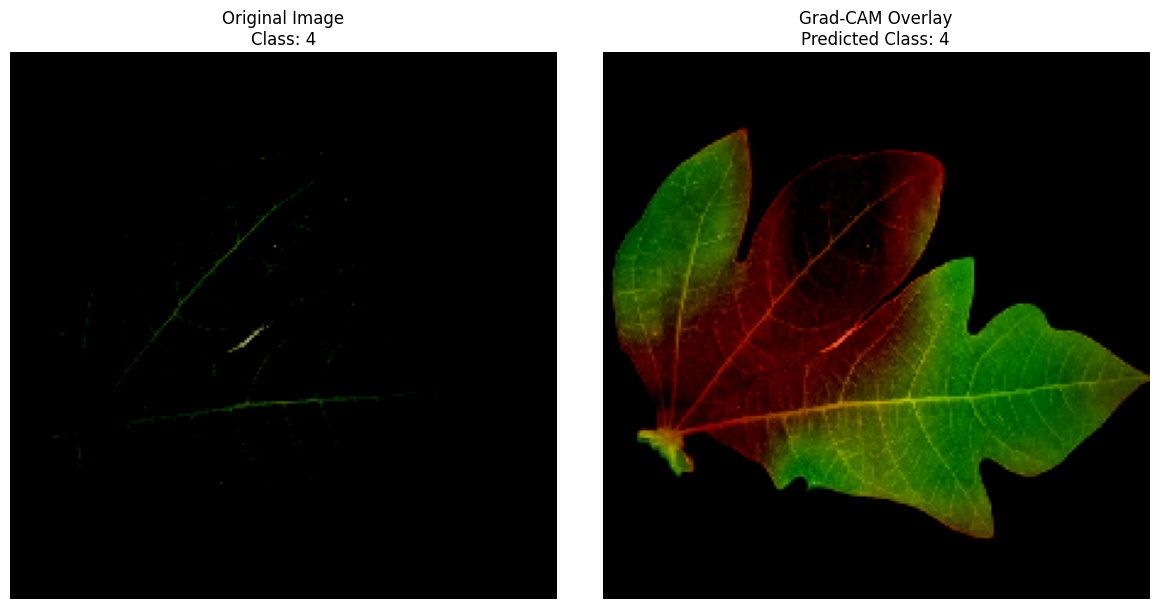

In [42]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Grad-CAM function to generate the heatmap for a specific model
def get_grad_cam(model, image, class_index, base_model_name):
    """Generate Grad-CAM for a single image and class index"""
    
    # Identify the last convolutional layer for each model
    if base_model_name == 'efficientnet':
        last_conv_layer = model.get_layer('top_conv')  # Adjust this name according to your model's layer names
    elif base_model_name == 'xception':
        last_conv_layer = model.get_layer('block14_sepconv2')  # Xception last conv layer
    elif base_model_name == 'densenet':
        last_conv_layer = model.get_layer('conv5_block16_2_conv')  # DenseNet201 last conv layer
    else:
        raise ValueError("Unknown model type for Grad-CAM")

    # Create the Grad-CAM model
    grad_model = tf.keras.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        # Watch the model's weights
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_index]  # Use the predicted class to compute the loss

    # Get the gradients of the predicted class w.r.t the last conv layer
    grads = tape.gradient(loss, conv_output)

    # Pool the gradients over all the axes except for the channels
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Multiply the weights of the filters with the activation map
    conv_output = conv_output[0]  # Use the first image in the batch
    cam = np.dot(conv_output, pooled_grads)

    # Rescale the cam to fit the image size
    cam = np.maximum(cam, 0)  # ReLU activation to keep only positive parts
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))  # Resize to input size

    # Normalize to [0, 1]
    cam = cam / np.max(cam)

    return cam


def grad_cam_overlay(image, cam):
    """Overlay Grad-CAM heatmap on the original image"""
    cam = np.uint8(255 * cam)  # Normalize the heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Apply a colormap
    heatmap = np.float32(heatmap) / 255  # Normalize to [0, 1]
    
    # Overlay heatmap onto original image
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)  # Normalize to [0, 1]
    
    return overlay

# Example usage for Grad-CAM on an individual model
def run_grad_cam(image, class_index, model, base_model_name):
    """Run Grad-CAM for the specified model and display results"""
    # Get Grad-CAM
    cam = get_grad_cam(model, tf.convert_to_tensor(np.expand_dims(image, axis=0)), class_index, base_model_name)
    
    # Overlay the Grad-CAM on the original image
    grad_cam_img = grad_cam_overlay(image, cam)
    
    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image\nClass: {class_index}")
    plt.axis('off')

    # Plot Grad-CAM overlay
    plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_img)
    plt.title(f"Grad-CAM Overlay\nPredicted Class: {class_index}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load an image from your dataset (example with test_ds)
for batch_x, batch_y in test_ds.take(1):  # Take one batch from the test dataset
    image = batch_x[0].numpy()  # Get the first image in the batch
    true_label = np.argmax(batch_y[0].numpy())  # Get the true label for the image
    break  # Exit the loop after one image

# Example: Class index (can be replaced by predicted class index)
class_index = true_label  # Use true label for visualization or replace with predicted class index

# Assuming 'efficientnet', 'xception', or 'densenet' are the models you're using
run_grad_cam(image, class_index, efficientnet, 'efficientnet')


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2
import os

# Function to calculate Grad-CAM
def get_grad_cam(model, img_array, class_index, layer_name="top_conv"):
    """Generate Grad-CAM for a single image and class index"""
    # Get the model's last convolutional layer
    last_conv_layer = model.get_layer(layer_name)
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])
    
    # Compute the gradient of the predicted class with respect to the output feature map
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Get the gradients of the loss w.r.t. the feature map
    grads = tape.gradient(loss, conv_output)
    
    # Pooling the gradients across all the axes (height and width of the feature map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map by the pooled gradients
    conv_output = conv_output[0]
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Create a heatmap by averaging over all the channels
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[1], img_array.shape[2]))  # Resize heatmap to match original image size
    heatmap = heatmap / np.max(heatmap)  # Normalize the heatmap

    return heatmap

# Function to overlay Grad-CAM heatmap on the original image
def grad_cam_overlay(original_img, heatmap, alpha=0.4):
    """Overlay the Grad-CAM heatmap on top of the original image"""
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    original_img = np.float32(original_img) / 255.0
    overlayed_img = heatmap * alpha + original_img
    overlayed_img = overlayed_img / np.max(overlayed_img)
    return overlayed_img

# Load image folder and iterate over all images per class
image_folder = "/path/to/your/images/folder"  # Set your images folder path
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]  # Your class names
num_classes = len(class_names)

# Assuming 'ensemble_model' is your trained model
for class_idx in range(num_classes):
    img_path = os.path.join(image_folder, f"class_{class_idx}_image.jpg")  # Modify according to the actual filenames
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adding batch dimension

    # Get Grad-CAM heatmap for the given class
    heatmap = get_grad_cam(ensemble_model, img_array, class_idx)

    # Overlay Grad-CAM on the original image
    original_img = cv2.cvtColor(img_array[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
    grad_cam_img = grad_cam_overlay(original_img, heatmap)

    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image\nClass: {class_names[class_idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_img)
    plt.title(f"Grad-CAM Overlay\nPredicted Class: {class_names[class_idx]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/images/folder/class_0_image.jpg'

In [28]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


Showing SHAP heatmaps for all 1 classes


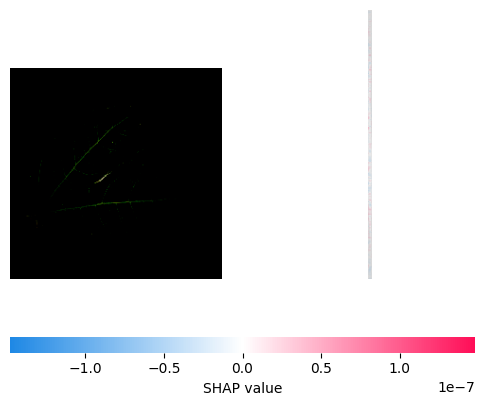

True Label: healthy_leaf


In [29]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------------------------
# Step 1: Prepare test dataset for ensemble input
# ---------------------------
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# ---------------------------
# Step 2: Extract background images for SHAP
# ---------------------------
background_images = []
for (x1, _, _), _ in test_ds_ensemble.take(10):  # take more batches for better background
    background_images.append(x1.numpy())
background_images = np.concatenate(background_images, axis=0)
background_images = background_images[:100]  # limit to 100 samples

# ---------------------------
# Step 3: Define ensemble prediction function
# ---------------------------
def ensemble_predict_for_shap(images):
    inputs = [images, images, images]
    preds = ensemble_model.predict(inputs)
    return preds

# ---------------------------
# Step 4: Create SHAP explainer
# ---------------------------
explainer = shap.GradientExplainer(ensemble_model, [background_images] * 3)

# ---------------------------
# Step 5: Select a test image for explanation
# ---------------------------
for (batch_x1, batch_x2, batch_x3), batch_y in test_ds_ensemble.take(1):
    test_images = batch_x1[0:1].numpy()  # shape (1, H, W, C)
    true_label = np.argmax(batch_y[0].numpy())
    break

# ---------------------------
# Step 6: Compute SHAP values
# ---------------------------
shap_values_raw = explainer.shap_values([test_images, test_images, test_images])  # 3 inputs → 7 class outputs

# ---------------------------
# Step 7: Aggregate SHAP values from the 3 inputs (ensemble)
# ---------------------------
# shap_values_raw shape: [3][7][1, H, W, C] => convert to [7][1, H, W, C]
shap_values = []
num_classes = len(shap_values_raw[0])
for class_idx in range(num_classes):
    sum_shap = np.sum([
        shap_values_raw[0][class_idx],
        shap_values_raw[1][class_idx],
        shap_values_raw[2][class_idx]
    ], axis=0)
    shap_values.append(sum_shap)

# ---------------------------
# Step 8: Visualize SHAP image explanations for all classes
# ---------------------------
print(f"Showing SHAP heatmaps for all {num_classes} classes")
shap.image_plot(shap_values, test_images)

print(f"True Label: {class_names[true_label]}")


2025-08-10 20:57:48.619958: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TypeError: Invalid shape (224, 224, 3, 6) for image data

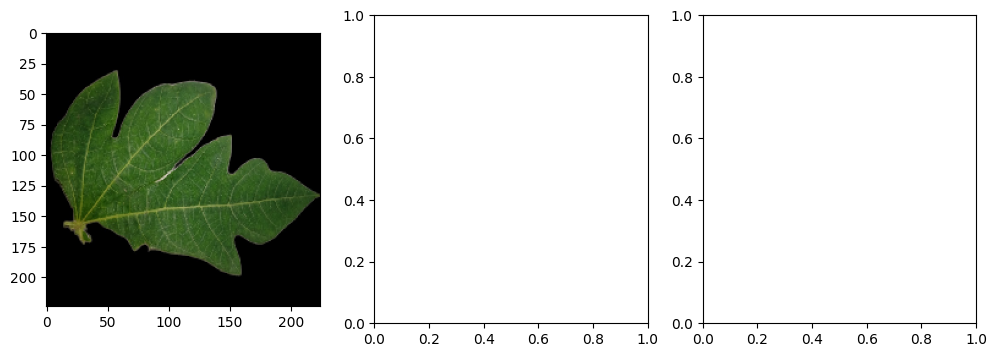

In [30]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Prepare test dataset with 3 identical inputs (if not already done)
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# Step 2: Extract representative background images from x1 input
background_images = []
for (x1, _, _), _ in test_ds_ensemble.unbatch().take(100):
    background_images.append(x1.numpy())
background_images = np.array(background_images)

# Step 3: Define prediction wrapper for SHAP
def ensemble_predict_for_shap(images):
    # Replicate input across all 3 ensemble branches
    input_batch = [images, images, images]
    return ensemble_model.predict(input_batch)

# Step 4: Initialize SHAP explainer
explainer = shap.GradientExplainer(ensemble_model, [background_images]*3)

# Step 5: Show SHAP explanations for 7 classes using one test image
for (x1_batch, _, _), y_batch in test_ds_ensemble.take(1):
    test_image = x1_batch[0:1].numpy()   # Shape: (1, 224, 224, 3)
    true_label = np.argmax(y_batch[0].numpy())
    break

# Step 6: Compute SHAP values for the test image
shap_values = explainer.shap_values([test_image]*3)

# Step 7: Visualize SHAP for all classes
num_classes = len(shap_values)
fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))

for i in range(num_classes):
    # shap_values[i][0] shape: (224, 224, 3)
    heatmap = shap_values[i][0]
    img_to_plot = test_image[0]  # Shape: (224, 224, 3)

    axes[i].imshow((img_to_plot * 0.5 + 0.5))  # Normalize to [0,1] range
    axes[i].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i].set_title(f"Class: {class_names[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"True Label: {class_names[true_label]}")


In [29]:
import numpy as np
from sklearn.model_selection import KFold

# Step 1: Extract all images and labels from tf.data.Dataset (e.g., train_ds_full)
images = []
labels = []

for img_batch, label_batch in train_ds_full:  # <-- use your dataset name here
    images.extend(img_batch.numpy())
    labels.extend(label_batch.numpy())

X = np.array(images)
y = np.array(labels)

# Step 2: Optional — convert one-hot labels to categorical if needed
if y.ndim == 2:  # one-hot encoded
    y = np.argmax(y, axis=1)

# Now X and y are ready for K-Fold
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


NameError: name 'train_ds_full' is not defined

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize y_true and y_pred for ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
y_pred_bin = y_pred_probs  # Already probabilities

# Compute macro ROC AUC
roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro")
print(f"Macro-average ROC AUC: {roc_auc:.3f}")


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(val_acc_per_fold, label='Validation Accuracy')
plt.plot(val_loss_per_fold, label='Validation Loss')
plt.title('Validation Accuracy and Loss across Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
